In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
%matplotlib inline

# Data
The data we will be using is hourly air pollution  data from BANDA. Air pollution  has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PM 2.5 data which has data from 2019-2021.

In [246]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [12,8]

In [5]:
foo = r'C:\Users\ACER\Desktop\python project\airqo/BandaHourly.csv'

In [264]:
df = pd.read_csv(foo,index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

In [265]:
df

,s2_pm2_5
Date,
2019-11-27 13:00:00,39.366842
2019-11-27 14:00:00,33.868718
2019-11-27 15:00:00,38.259744
2019-11-27 16:00:00,73.879048
2019-11-27 17:00:00,75.360000
...,...
2021-11-15 19:00:00,50.853721
2021-11-15 20:00:00,37.073437
2021-11-15 21:00:00,53.398000


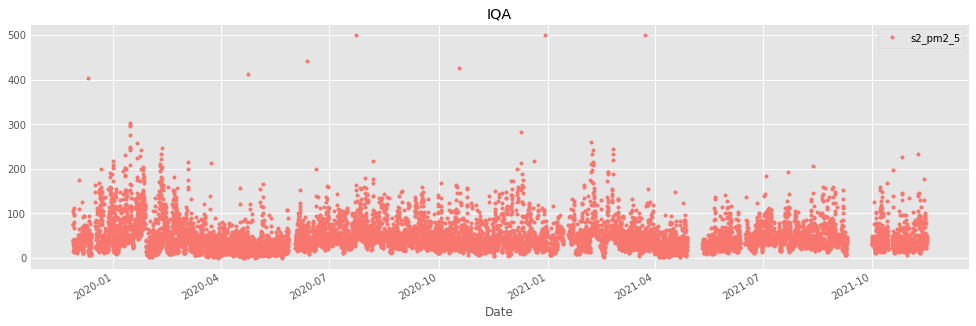

In [266]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='IQA')
plt.show()

# EDA
We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [205]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='s2_pm2_5')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-205-3c4d4b9979ca>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear


In [208]:
def create_features(df, label=None):
   
    # Get date variables. 
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['day_of_month'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    df['daysinmonth'] = df['Date'].dt.daysinmonth
    df['week'] = df['Date'].dt.week
    
    # Time Series Components 
    ## Trend
    ## Seasonal
    df['monthly_seas'] = np.cos(2*np.pi*df['day_of_month']/df['daysinmonth'])
    df['yearly_seas'] = 1.2*(np.sin(np.pi*df['month']/3) + np.cos(2*np.pi*df['month']/4))
    df['end_of_year']= - 8.5*np.exp(- ((df['week'] - 51.5)/1.0)**2) \
   
    X = df[['hour','dayofweek','quarter','month','year',
           'day_of_year','day_of_month','end_of_year','weekofyear','monthly_seas','yearly_seas']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='s2_pm2_5')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-208-930fbaae6b02>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear
<ipython-input-208-930fbaae6b02>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['Date'].dt.week


In [260]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,day_of_year,day_of_month,end_of_year,weekofyear,monthly_seas,yearly_seas,s2_pm2_5
Date,,,,,,,,,,,,
2019-11-27 13:00:00,13,2,4,11,2019,331,27,-0.000041,48,0.809017,-1.03923,39.366842
2019-11-27 14:00:00,14,2,4,11,2019,331,27,-0.000041,48,0.809017,-1.03923,33.868718
2019-11-27 15:00:00,15,2,4,11,2019,331,27,-0.000041,48,0.809017,-1.03923,38.259744
2019-11-27 16:00:00,16,2,4,11,2019,331,27,-0.000041,48,0.809017,-1.03923,73.879048
2019-11-27 17:00:00,17,2,4,11,2019,331,27,-0.000041,48,0.809017,-1.03923,75.360000


# Plotting the Features to see trends
PM 2.5 strong daily and seasonal properties.
Day of week also seems to show differences in peaks

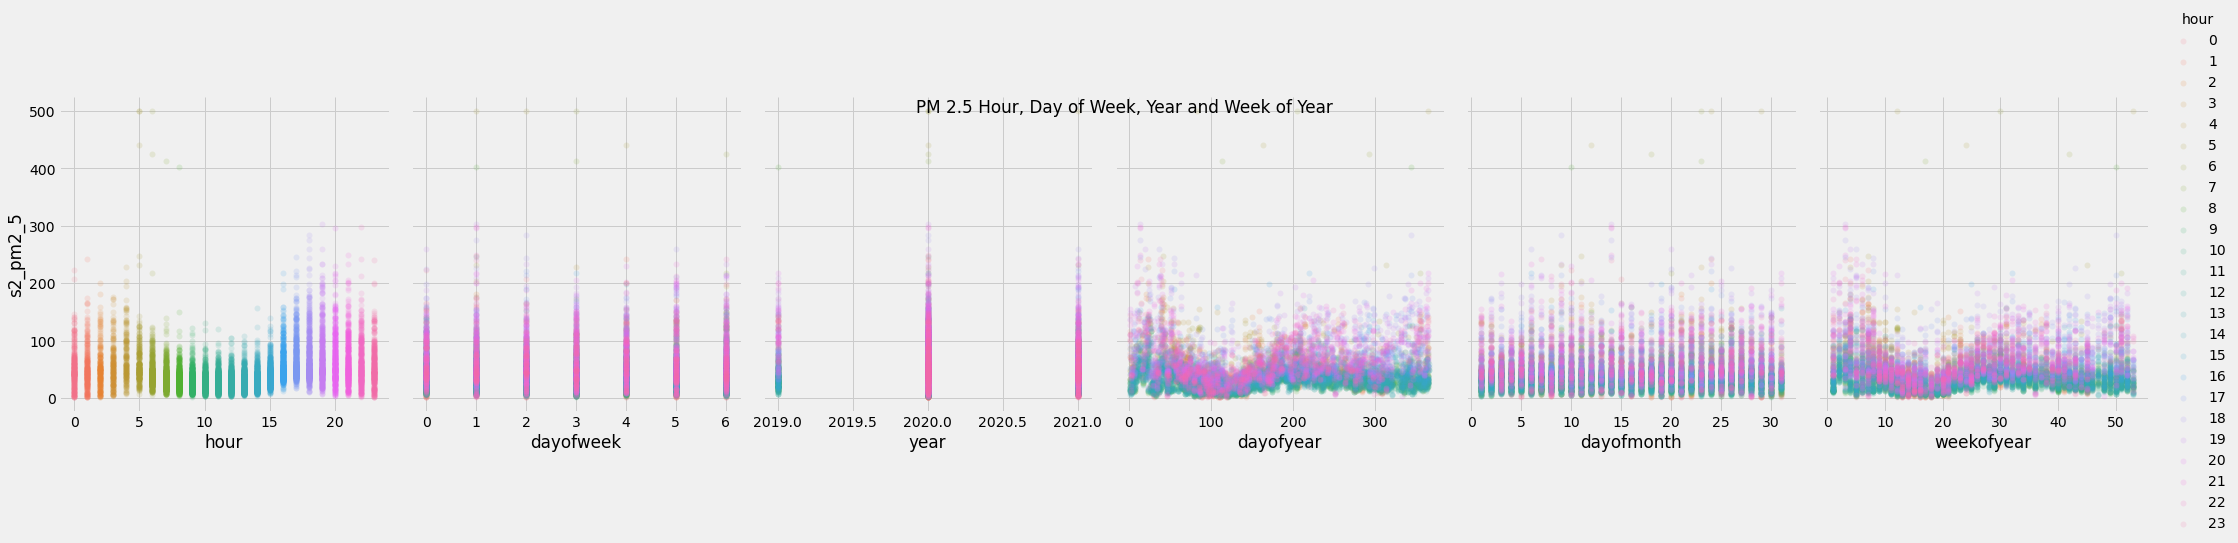

In [124]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','dayofyear','dayofmonth','weekofyear'],
             y_vars='s2_pm2_5',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('PM 2.5 Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split
Cut off the data BEFORE 2021 to use as our validation set. We will train on earlier data.

In [16]:
split_date = '01-May-2021'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

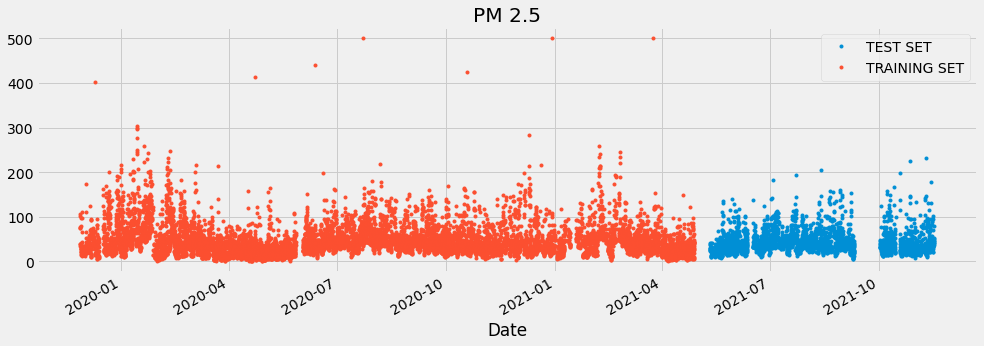

In [210]:
df_test \
    .rename(columns={'s2_pm2_5': 'TEST SET'}) \
    .join(df_train.rename(columns={'s2_pm2_5': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PM 2.5', style='.')
plt.show()

# Simple Prophet Model¶
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model

In [19]:
# Format data for prophet model using ds and y
df_train.reset_index() \
    .rename(columns={'Date':'ds',
                     's2_pm2_5':'y'}).head()

,ds,y
0,2019-11-27 13:00:00,39.366842
1,2019-11-27 14:00:00,33.868718
2,2019-11-27 15:00:00,38.259744
3,2019-11-27 16:00:00,73.879048
4,2019-11-27 17:00:00,75.360000


# Model

In [127]:
# Setup and train model and fit
model = Prophet(yearly_seasonality = True)

model.fit(df_train.reset_index() \
              .rename(columns={'Date':'ds',
                               's2_pm2_5':'y'}))

In [128]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index() \
                                   .rename(columns={'Date':'ds'}))

In [129]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-11 06:00:00,58.603534,-2.251974,71.646813,58.156061,59.058829,-22.839831,-22.839831,-22.839831,-0.715242,...,1.003021,1.003021,1.003021,-23.127610,-23.127610,-23.127610,0.0,0.0,0.0,35.763703
1,2021-05-11 07:00:00,58.610693,-14.363763,61.977721,58.161662,59.067759,-35.263855,-35.263855,-35.263855,-13.201534,...,1.080098,1.080098,1.080098,-23.142419,-23.142419,-23.142419,0.0,0.0,0.0,23.346838
2,2021-05-11 08:00:00,58.617852,-22.406828,53.876864,58.166328,59.076689,-43.102093,-43.102093,-43.102093,-21.094077,...,1.149179,1.149179,1.149179,-23.157195,-23.157195,-23.157195,0.0,0.0,0.0,15.515759
3,2021-05-11 09:00:00,58.625010,-21.671908,51.362285,58.170994,59.085619,-44.694884,-44.694884,-44.694884,-22.732381,...,1.209432,1.209432,1.209432,-23.171936,-23.171936,-23.171936,0.0,0.0,0.0,13.930126
4,2021-05-11 10:00:00,58.632169,-20.389176,51.578753,58.175813,59.094549,-43.203823,-43.203823,-43.203823,-21.277306,...,1.260124,1.260124,1.260124,-23.186642,-23.186642,-23.186642,0.0,0.0,0.0,15.428346


# Plot the forecast

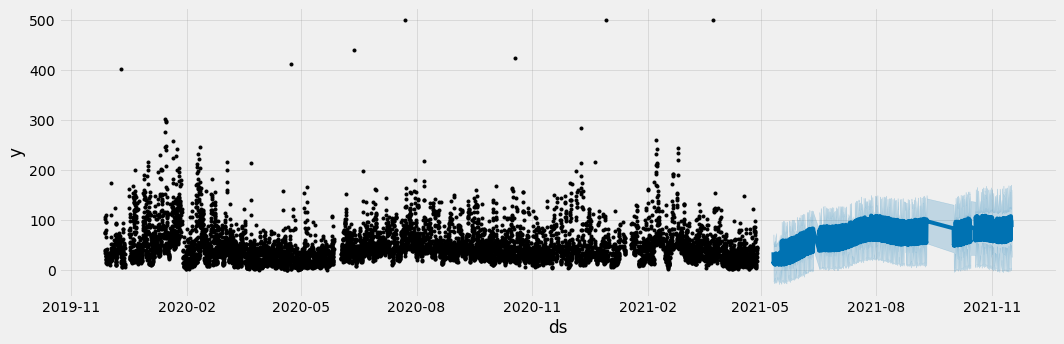

In [130]:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

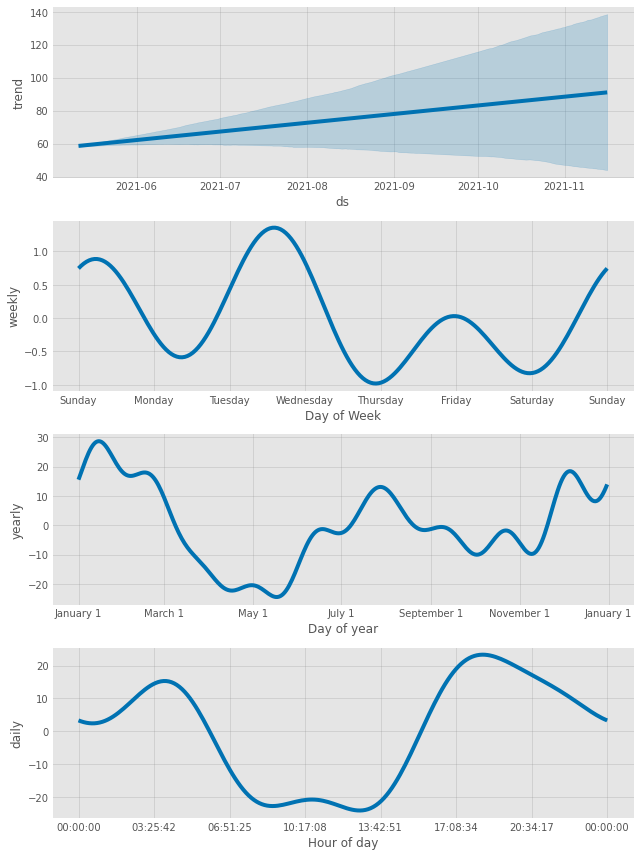

In [259]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

# Compare Forecast to Actuals

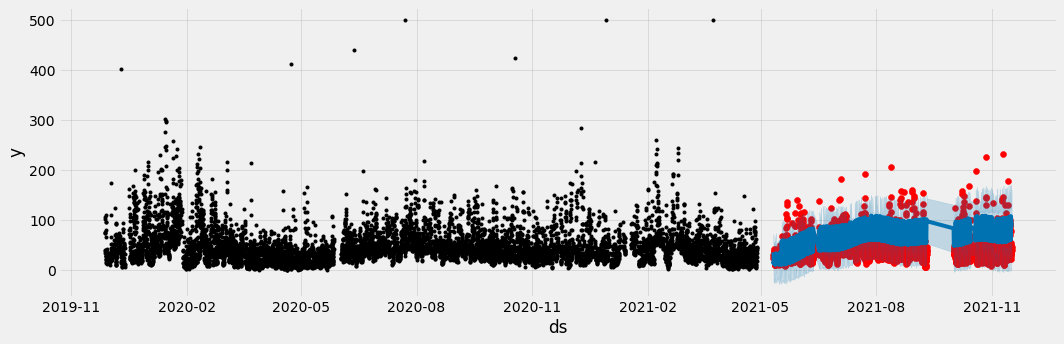

In [132]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['s2_pm2_5'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

# Look at ____ month of predictions

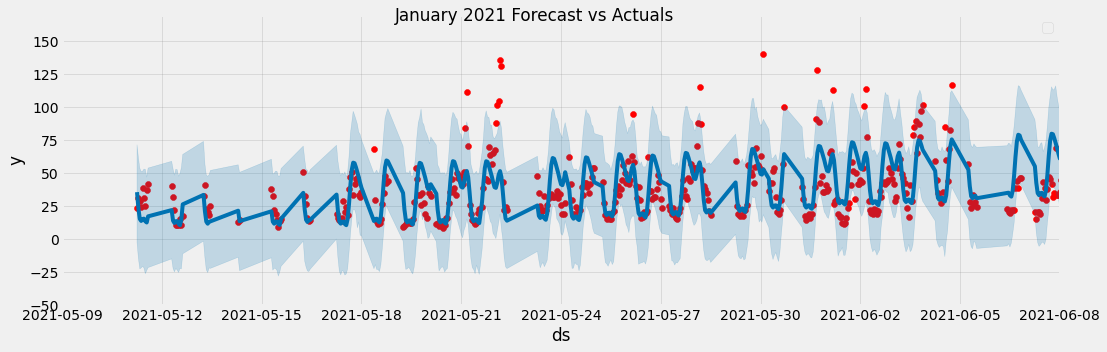

In [133]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['s2_pm2_5'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound((pd.to_datetime("2021-05-09"),pd.to_datetime("2021-06-08")))
ax.set_ylim(-50, 170)
plt.legend()
plot = plt.suptitle('January 2021 Forecast vs Actuals')


# Single Week of Predictions

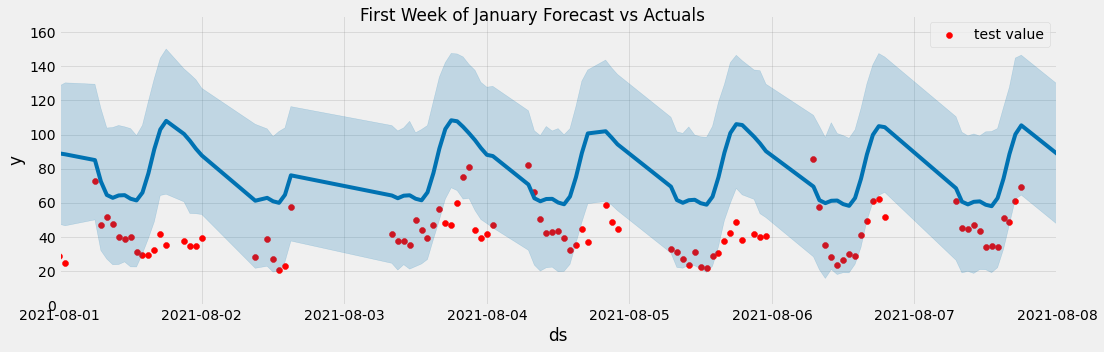

In [135]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['s2_pm2_5'], color='r',label='test value')
fig = model.plot(df_test_fcst, ax=ax)
#ax.set_xbound(lower='01-01-2021', upper='01-08-2021')

ax.set_xbound((pd.to_datetime("2021-08-01"),pd.to_datetime("2021-08-08")))
ax.set_ylim(0, 170)
plot = plt.suptitle('First Week of January Forecast vs Actuals')
plt.legend()

In [136]:
mean_squared_error(y_true=df_test['s2_pm2_5'],
                   y_pred=df_test_fcst['yhat'])

1022.2578750529514

In [137]:
mean_absolute_error(y_true=df_test['s2_pm2_5'],
                   y_pred=df_test_fcst['yhat'])

26.883611122156694

In [138]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['s2_pm2_5'],
                   y_pred=df_test_fcst['yhat'])

82.90421061470785

In [139]:

# Define threshold date.
threshold_date = pd.to_datetime('2021-05-01')
mask = df_test_fcst['ds'] < threshold_date

In [140]:
df

,s2_pm2_5
Date,
2019-11-27 13:00:00,39.366842
2019-11-27 14:00:00,33.868718
2019-11-27 15:00:00,38.259744
2019-11-27 16:00:00,73.879048
2019-11-27 17:00:00,75.360000
...,...
2021-11-15 19:00:00,50.853721
2021-11-15 20:00:00,37.073437
2021-11-15 21:00:00,53.398000



# Holidays
Holidays: End of the Year

In most of the resources available, Prophet is applied to daily data. Here we are interested in the specific case of weekly data. The generalization is pretty straightforward. Nevertheless, There are some important aspects one needs to be particularly careful about.

According to the documentation, we can model specific special events by explicitly including them into a holidays data frame which must have at least two columns ds: date stamp and holiday: name of the event. In addition, we can include two columns lower_window and upper_window which extend the event time stamp to the interval [ds - lower_window, ds + upper_window] in days.

Warning: The holidays data frame must contain the events in the historical data and also in the future.

In [111]:
def create_end_of_year_holydays_df():
    """Create holidays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2019-12-25', '2020-12-25', '2021-12-25', '2021-12-25']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays

# Build Model

In [113]:
def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holydays_df()
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
        mcmc_samples = 500
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
    return model
    
model = build_model()

# Generate Predictions

In [267]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='W')
# Generate predictions. 
forecast = model.predict(df=future)

In [213]:
for c in forecast.columns.sort_values():
    print(c)

additive_terms
additive_terms_lower
additive_terms_upper
daily
daily_lower
daily_upper
ds
multiplicative_terms
multiplicative_terms_lower
multiplicative_terms_upper
trend
trend_lower
trend_upper
weekly
weekly_lower
weekly_upper
yearly
yearly_lower
yearly_upper
yhat
yhat_lower
yhat_upper


In [215]:
forecast[forecast['yearly'].abs()>0][['ds', 'yearly']]

,ds,yearly
0,2019-11-27 13:00:00,11.959443
1,2019-11-27 14:00:00,12.020176
2,2019-11-27 15:00:00,12.080702
3,2019-11-27 16:00:00,12.141020
4,2019-11-27 17:00:00,12.201128
...,...,...
11436,2068-12-16 02:00:00,11.209243
11437,2068-12-23 02:00:00,8.221950
11438,2068-12-30 02:00:00,13.120748
11439,2069-01-06 02:00:00,22.463884


In [227]:
# Define threshold date.
threshold_date = pd.to_datetime('2021-05-01')
mask = df_test_fcst['ds'] < threshold_date

mask2 = forecast['ds'] < threshold_date

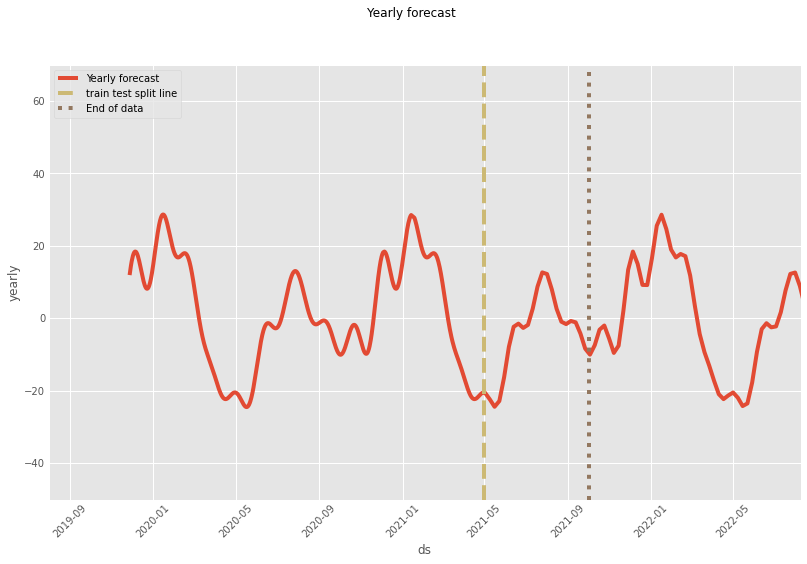

In [254]:
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots()



sns.lineplot(x='ds', y='yearly', data=forecast, ax=ax, label='Yearly forecast')
ax.axvline(threshold_date, color=sns_c[8], linestyle='--', label='train test split line')
ax.axvline(pd.to_datetime('2021-10-01'), color=sns_c[5], linestyle='dotted', label='End of data')

#ax.set(title='end_of_yearly', ylabel='');
ax.set_xbound((pd.to_datetime("2019-08-01"),pd.to_datetime("2022-08-08")))

plot = plt.suptitle('Yearly forecast')
plt.legend()

ax.set_ylim(-50, 70)
plt.xticks(rotation=45)
ax.legend(loc=2)

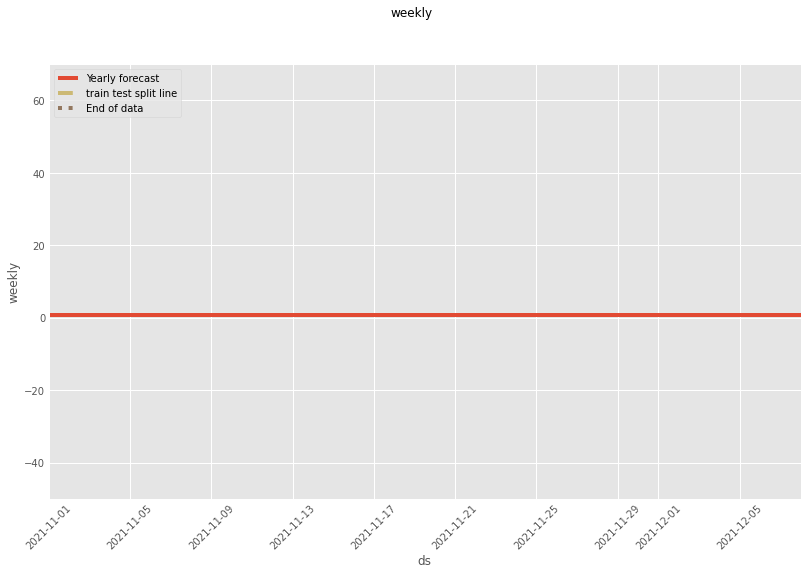

In [268]:
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots()



sns.lineplot(x='ds', y='weekly', data=forecast, ax=ax, label='Yearly forecast')
ax.axvline(threshold_date, color=sns_c[8], linestyle='--', label='train test split line')
ax.axvline(pd.to_datetime('2021-10-01'), color=sns_c[5], linestyle='dotted', label='End of data')

#ax.set(title='end_of_yearly', ylabel='');
ax.set_xbound((pd.to_datetime("2021-11-01"),pd.to_datetime("2021-12-08")))

plot = plt.suptitle('weekly')
plt.legend()

ax.set_ylim(-50, 70)
plt.xticks(rotation=45)
ax.legend(loc=2)

In [230]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

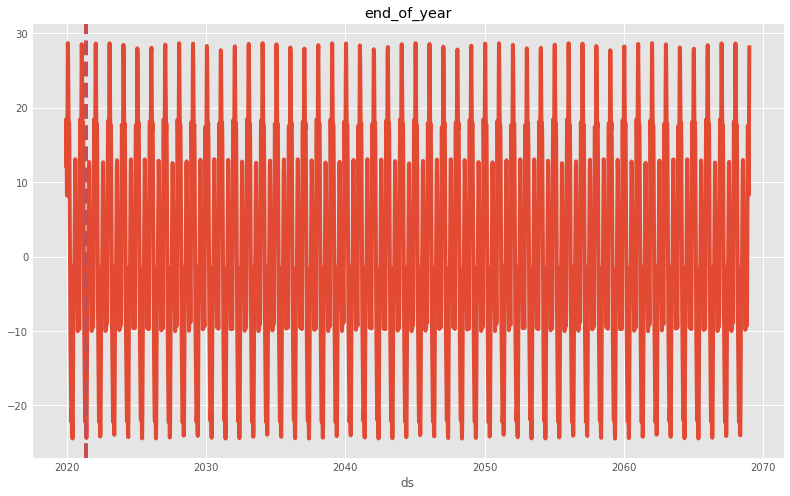

In [270]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='yearly', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.set(title='end_of_year', ylabel='');

In [261]:
features_and_target

,hour,dayofweek,quarter,month,year,day_of_year,day_of_month,end_of_year,weekofyear,monthly_seas,yearly_seas,s2_pm2_5
Date,,,,,,,,,,,,
2019-11-27 13:00:00,13,2,4,11,2019,331,27,-4.067350e-05,48,0.809017,-1.03923,39.366842
2019-11-27 14:00:00,14,2,4,11,2019,331,27,-4.067350e-05,48,0.809017,-1.03923,33.868718
2019-11-27 15:00:00,15,2,4,11,2019,331,27,-4.067350e-05,48,0.809017,-1.03923,38.259744
2019-11-27 16:00:00,16,2,4,11,2019,331,27,-4.067350e-05,48,0.809017,-1.03923,73.879048
2019-11-27 17:00:00,17,2,4,11,2019,331,27,-4.067350e-05,48,0.809017,-1.03923,75.360000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15 19:00:00,19,0,4,11,2021,319,15,-6.194565e-13,46,-1.000000,-1.03923,50.853721
2021-11-15 20:00:00,20,0,4,11,2021,319,15,-6.194565e-13,46,-1.000000,-1.03923,37.073437
2021-11-15 21:00:00,21,0,4,11,2021,319,15,-6.194565e-13,46,-1.000000,-1.03923,53.398000
